# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image 

# Define dataset parameters


In [2]:
image_height = 224
image_width = 224
num_channels = 3
batch_size = 32
num_classes = 2

# Get Image From each Directory ( Visualization)


In [3]:
data_path=r'/kaggle/input/drone-vs-bird/dataset'
image_classes = os.listdir(data_path)
print(image_classes)

['bird', 'drone']


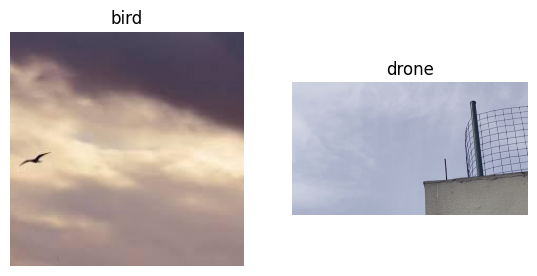

In [4]:
def plot_image(image_classes):
    plt.figure(figsize=(14 , 14))
    
    for i , category in enumerate(image_classes):
        image_path = data_path + '/' + category
        images_in_folder = os.listdir(image_path)
        
        first_image = images_in_folder[0]
        first_image_path = image_path + '/' + first_image 
        
        img= image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(4 , 4 , i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()
plot_image(image_classes)

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for training and validation
)

# Preprocessing Data & Split Data into Train & Test


In [6]:
train_data = train_datagen.flow_from_directory(
    r'/kaggle/input/drone-vs-bird/dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

Found 3284 images belonging to 2 classes.


In [7]:
val_data = train_datagen.flow_from_directory(
    r'/kaggle/input/drone-vs-bird/dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 820 images belonging to 2 classes.


# Load the pre-trained MobileNetV2 model


In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
#Freeze the base model's layers to retain pre-trained weights
base_model.trainable = False

# Build the model

In [10]:
model = Sequential([
    base_model,  # Add the pre-trained model as the base
    GlobalAveragePooling2D(),  # Add a pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Dropout for regularization
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the Model


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the Model


In [13]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8394 - loss: 0.3818 - val_accuracy: 0.9110 - val_loss: 0.2432 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 781ms/step - accuracy: 0.9670 - loss: 0.0792 - val_accuracy: 0.9183 - val_loss: 0.2203 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 84s 770ms/step - accuracy: 0.9760 - loss: 0.0695 - val_accuracy: 0.9049 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 85s 786ms/step - accuracy: 0.9805 - loss: 0.0594 - val_accuracy: 0.9293 - val_loss: 0.2074 - learning_rate: 0.0010
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 85s 775ms/step - accuracy: 0.9842 - loss: 0.0540 - val_accuracy: 0.9317 - val_loss: 0.2411 - learning_rate: 0.0010
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 87s 787ms/step - accuracy: 0.9791 - loss: 0.0526 - val_accuracy: 0.9110 - val_loss: 0.2375 - learning_rate: 0.0010
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 85s 759ms/step - accuracy: 0.9846 - loss: 0

# Evaluate The Model Accuracy & Visualize Results

In [14]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.9355 - loss: 0.1923
Validation Loss: 0.2220740020275116
Validation Accuracy: 0.9231707453727722


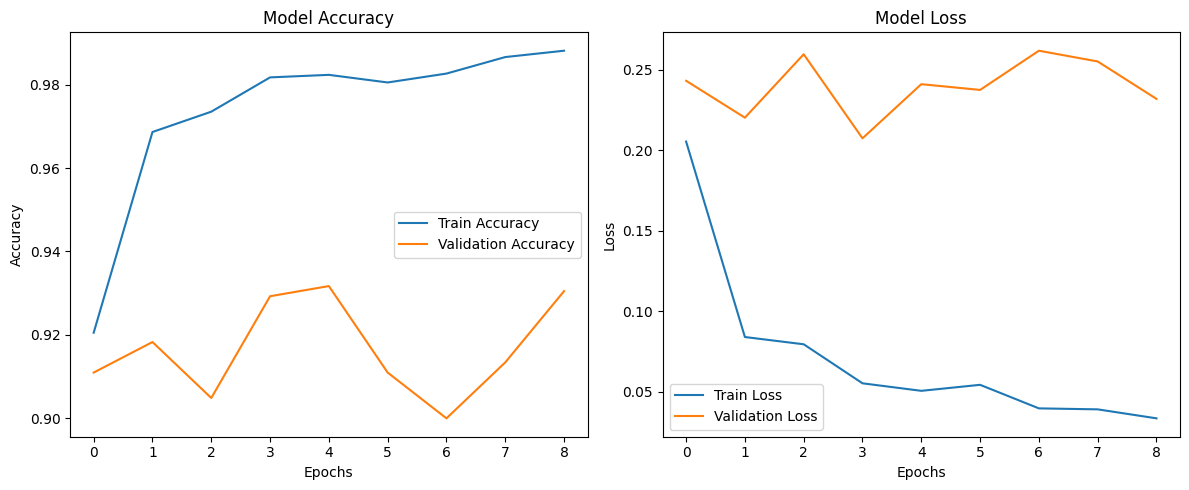

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Save Model as h5

In [16]:
# Save the final trained model
model.save("Drone vs Bird.h5")
